https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844

Install darts with

- conda create --name py_darts python=3.7
- conda activate py_darts
- pip install darts

How to add conda env as jupyter notebook kernel

https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

- activate new environment (conda activate py_darts)
- conda install -c anaconda ipykernel
- python -m ipykernel install --user --name=py_darts

In [2]:
#from darts.models import RNNModel

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Read Data
Let's start by reading two time series - one containing the monthly number of air passengers, and another containing the monthly milk production per cow. These time series have not much to do with each other, except that they both have a monthly frequency with a marked yearly periodicity and upward trend, and (completely coincidentaly) they contain values of a comparable order of magnitude.

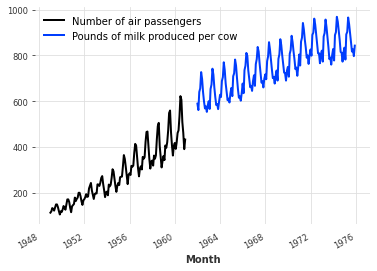

In [4]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend()

plt.show()

# Preprocessing

Usually neural networks tend to work better on normalised/standardised data. Here we'll use the Scaler class to normalise both of our time series between 0 and 1:

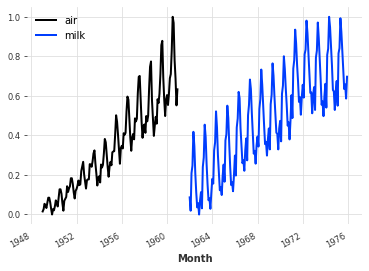

In [8]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend()
plt.show()

# Train / Validation split
Let's keep the last 36 months of both series as validation:

In [9]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

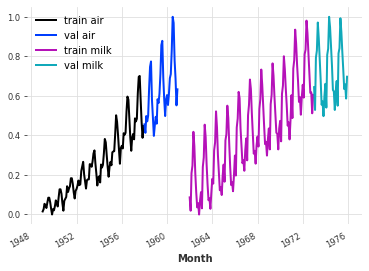

In [11]:
train_air.plot(label="train air")
val_air.plot(label="val air")

train_milk.plot(label="train milk")
val_milk.plot(label="val milk")

plt.legend()
plt.show()

# Example with One Series

Let's look at a first example. We'll build an N-BEATS model that has a lookback window of 24 points (input_chunk_length=24) and predicts the next 12 points (output_chunk_length=12). We chose these values so it'll make our model produce successive predictions for one year at a time, looking at the past two years.

In [12]:
model_air = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0
)

This model can be used like any other Darts forecasting model, beeing fit on a single time series:

In [13]:
model_air.fit(train_air, verbose=True)

[2022-02-20 19:26:09,425] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-02-20 19:26:09,425] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-02-20 19:26:09,501] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-20 19:26:09,501] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-20 19:26:09,503] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-20 19:26:09,503] WARNING | darts.models.forecasting.torch_forecasting_model | Deprecati

Training: 0it [00:00, ?it/s]

And like any other Darts forecasting models, we can then get a forecast by calling predict(). Note that below, we are calling predict() with a horizon of 36, which is longer than the model internal output_chunk_length of 12. That's not a problem here - as explained above, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

Predicting: 3it [00:00, ?it/s]

MAPE = 8.02%


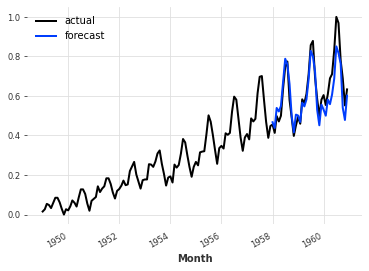

In [14]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))
plt.show()

# Training on Both Air Traffic and Milk Series

Let's look at another example where we fit another model instance on our two time series (air passengers and milk production). Since using two series of (roughly) the same length (roughly) doubles the training dataset size, we will use half of the number of epochs:

In [15]:
model_air_milk = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0
)

Then, fitting the model on two (or more) series is as simple as giving a list of series (instead of a single series) in argument to the fit() function:

In [16]:
model_air_milk.fit([train_air, train_milk], verbose=True)

[2022-02-20 19:35:44,450] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-02-20 19:35:44,450] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-02-20 19:35:44,528] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-20 19:35:44,528] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-20 19:35:44,530] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-20 19:35:44,530] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

## Producing Forecasts After the End of a Series

Now, importantly, when computing the forecasts we have to specify which time series we want to forecast the future for.

We didn't have this constraint earlier. When fitting models on one series only, the model remembers this series internally, and if predict() is called without the series argument, it returns a forecast for the (unique) training series. This does not work anymore as soon as a model is fit on more than one series - in this case the series argument of predict() becomes mandatory.

So, let's say we want to predict future of air traffic. In this case we specify series=train_air to the predict() function in order to say we want to get a forecast for what comes after train_air:

Predicting: 7it [00:00, ?it/s]

MAPE = 7.58%


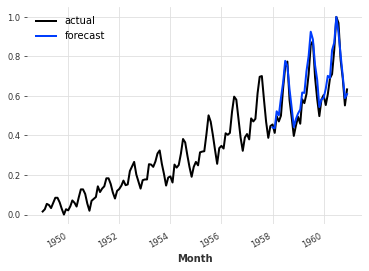

In [17]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))
plt.show()

# Wait... does this mean that milk consumption helps to predict air traffic??

Well, in this particular instance with this model, it seems to be the case (at least in terms of MAPE error). This is not so weird if you think about it, though. Air traffic is heavily characterized by the yearly seasonality and upward trend. The milk series exhibits these two traits as well, and in this case it's probably helping the model to capture them.

Note that this points towards the possibility of pre-training forecasting models; training models once and for all and later using them to forecast series that are not in the train set. With our toy model we can really forecast the future values of any other series, even series never seen during training. For the sake of example, let's say we want to forecast the future of some arbitrary sine wave series:

Predicting: 7it [00:00, ?it/s]

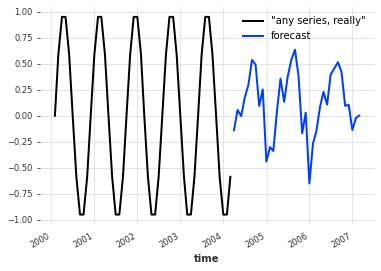

In [18]:
any_series = sine_timeseries(length=50, freq="M")
pred = model_air_milk.predict(n=36, series=any_series)

any_series.plot(label='"any series, really"')
pred.plot(label="forecast")
plt.legend()
plt.show()

This forecast isn't good (the sine doesn't even have a yearly seasonality), but you get the idea.

Similar to what is supported by the fit() function, we can also give a list of series in argument to the predict() function, in which case it will return a list of forecast series. For example, we can get the forecasts for both the air traffic and the milk series in one go as follows:

Predicting: 7it [00:00, ?it/s]

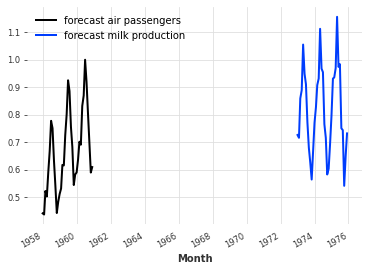

In [19]:
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for series, label in zip(pred_list, ["air passengers", "milk production"]):
    series.plot(label=f"forecast {label}")
plt.legend()
plt.show()

The two series returned correspond to the forecasts after then end of train_air and train_milk, respectively.

# Covariates Series

Until now, we have only been playing with models that only use the history of the target series to predict its future. However, as explained above, the global Darts models also support the use of covariates time series. These are time series of "external data", which we are not necessarily interested in predicting, but which we would still like to feed as input of our models because they can contain valuable information.

## Building Covariates
Let's see a simple example with our air and milk series, where we'll try to use the year and month-of-the-year as covariates:

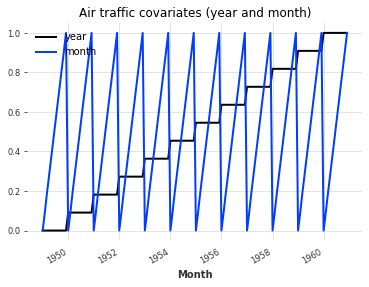

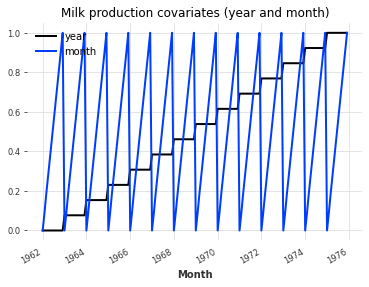

In [25]:
# build year and month series:
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

# stack year and month to obtain series of 2 dimensions (year and month):
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# scale them between 0 and 1:
scaler_dt_air = Scaler()
air_covariates = scaler_dt_air.fit_transform(air_covariates)

scaler_dt_milk = Scaler()
milk_covariates = scaler_dt_milk.fit_transform(milk_covariates)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

# plot the covariates:
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)")
plt.show()

Good, so for each target series (air and milk), we have built a covariates series having the same time axis and containing the year and the month.

Note that here the covariates series are multivariate time series: they contain two dimensions - one dimension for the year and one for the month.

## Training with Covariates
Let's revisit our example again, this time with covariates. We will build a BlockRNNModel here:

In [26]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=300,
    random_state=0,
)

Now, to train the model with covariates, it is as simple as providing the covariates (in form of a list matching the target series) as future_covariates argument to the fit() function. The argument is named future_covariates to remind us that the model can use future values of these covariates in order to make a prediction.

In [27]:
model_cov.fit(
    series=[train_air, train_milk],
    past_covariates=[air_train_covariates, milk_train_covariates],
    verbose=True,
)

[2022-02-20 19:51:32,057] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-02-20 19:51:32,057] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-02-20 19:51:32,063] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-20 19:51:32,063] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-20 19:51:32,064] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-20 19:51:32,064] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

## Forecasting with Covariates
similarly, getting a forecast is now only a matter of specifying the future_covariates argument to the predict() function.

Predicting: 7it [00:00, ?it/s]

MAPE = 14.76%


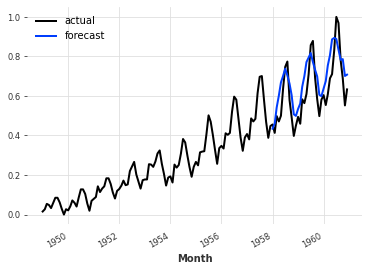

In [31]:
pred_cov = model_cov.predict(n=36, series=train_air, past_covariates=air_covariates)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred_cov)))
plt.legend()
plt.show()

Note that here we called predict() with a forecast horizon n that is larger than the output_chunk_length we trained our model with. We were able to do this because even though BlockRNNModel uses past covariates, in this case these covariates are also known into the future, so Darts is able to compute the forecasts auto-regressively for n time steps in the future.

## Backtesting with Covariates
We can also backtest the model using covariates. Say for instance we are interested in evaluating the running accuracy with a horizon of 12 months, starting at 75% of the air series:

  0%|          | 0/48 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

MAPE (using covariates) = 9.40%


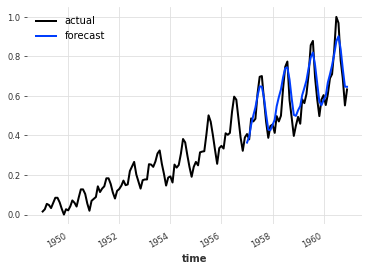

In [33]:
backtest_cov = model_cov.historical_forecasts(
    series_air_scaled,
    past_covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=True,
)

series_air_scaled.plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
print("MAPE (using covariates) = {:.2f}%".format(mape(series_air_scaled, backtest_cov)))

# A few more words on past covariates, future covariates and other conditioning
At the moment Darts supports covariates that are themselves time series. These covariates are used as model inputs, but are never themselves subject to prediction. The covariates do not necessarily have to be aligned with the target series (e.g. they do not need to start at the same time). Darts will use the actual time values of the TimeSeries time axes in order to jointly slice the targets and covariates correctly, both for training and inference. Of course the covariates still need to have a sufficient span, otherwise Darts will complain.

As explained above, TCNModel, NBEATSModel, BlockRNNModel, TransformerModel use past covariates (they will complain if you try using future_covariates). If these past covariates happen to also be known into the future, then these models are also able to produce forecasts for n > output_chunk_length (as shown above for BlockRNNModel) in an auto-regressive way.

By contrast, RNNModel uses future covariates (it will complain if you try specifying past_covariates). This means that prediction with this model requires the covariates (at least) n time steps into the future after prediction time.

Past and future covariates (as well as the way they are consummed by the different models) an important but non-trivial topic, and we plan to dedicate a future notebook (or article) to explain this further.

At the time of writing, Darts does not support covariates that are not time series - such as for instance class label informations or other conditioning variables. One trivial (although likely suboptimal) way to go around this is to build time series filled with constant values encoding the class labels. Supporting more general types of conditioning is a future feature on the Darts development roadmap.